Plot the particle distribution with matplotlib, with increasing complexity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from postladim import ParticleFile

### Settings

In [2]:
# Files
particle_file = "out.nc"
grid_file = "../data/ocean_avg_0014.nc"

# Time step
t = 48    # 6 days (3 hours between output)

### Read particle position

In [3]:
# Read the particle_file

with ParticleFile(particle_file) as pf:
    X, Y = pf.position(t)

### Mininal plot

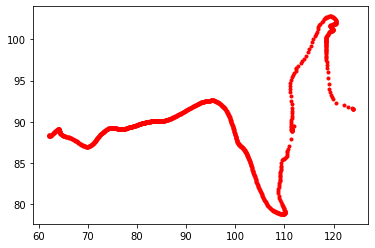

In [4]:
plt.plot(X, Y, 'r.');

Use the grid file to add land mask and lat/lon lines. 
The particles are in the northern North Sea.
Great Britain looks a bit small compared to Denmark and South-Western Norway.
This is due to the unusual map projection used by ROMS to produce the current field.
The map projection is orthogonal, so the shape of the land masses is correct, provided matplotlib don't mess up the aspect ratio.

In [5]:
grid = xr.load_dataset(grid_file)

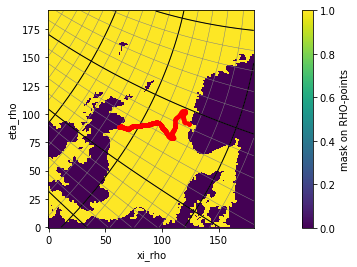

In [6]:
# Land mask
grid.mask_rho.plot()
# Graticule
grid.lon_rho.plot.contour(levels=range(-18, 14, 2),
            linewidths=0.5, linestyles='-', colors='grey')
grid.lon_rho.plot.contour(levels=range(-10, 11, 10),
            linewidths=1.0, linestyles='-', colors='k')
grid.lat_rho.plot.contour(levels=range(50, 66),
            linewidths=0.5, linestyles='-', colors='grey')
grid.lat_rho.plot.contour(levels=range(50, 66, 5),
            linewidths=1.0, linestyles='-', colors='k')
# Particles
plt.plot(X, Y, 'r.')
# Aspect ratio
plt.axis("image");

Zoom in on a subgrid.
Add the bottom topography, also from the grid file.
Make the colour map for the land mask transparent at sea.
Put a time stamp in the title.

In [7]:
# Define subgrid
i0, i1, j0, j1 = 55, 150, 55, 145

# Cell centers and cell boundaries
Xc = np.arange(i0, i1)
Yc = np.arange(j0, j1)
Xb = np.arange(i0 - 0.5, i1)
Yb = np.arange(j0 - 0.5, j1)

In [8]:
subgrid = grid.sel(xi_rho=slice(i0, i1), eta_rho=slice(j0,j1))
H = subgrid.h
M = subgrid.mask_rho

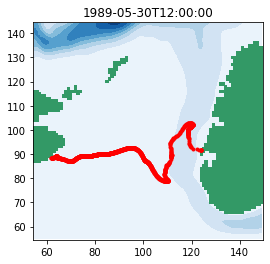

In [9]:
# Bottom topography background
plt.contourf(Xc, Yc, H, cmap='Blues')

# Landmask
land_colour = plt.matplotlib.colors.ListedColormap([0.2, 0.6, 0.4])
M = np.ma.masked_where(M > 0, M)
plt.pcolormesh(Xb, Yb, M, cmap=land_colour)

# Particles
plt.plot(X, Y, 'r.')

# Time stamp
plt.title(pf.time(t))
plt.axis("image");

A more complete plot, with lon/lat lines and without the grid labels.

##### 

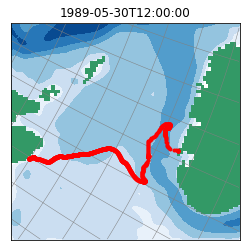

In [10]:
# Bottom topography background
depth_levels = [25, 50, 100, 250, 500, 1000, 2500]
plt.contourf(Xc, Yc, np.log(subgrid.h), levels=np.log(depth_levels), cmap='Blues')

# Landmask
land_colour = plt.matplotlib.colors.ListedColormap([0.2, 0.6, 0.4])
M = np.ma.masked_where(subgrid.mask_rho > 0, subgrid.mask_rho)
plt.pcolormesh(Xb, Yb, M, cmap=land_colour)

# Graticule
plt.contour(Xc, Yc, subgrid.lon_rho, levels=range(-14, 10, 2),
            linewidths=0.5, linestyles='-', colors='grey')
plt.contour(Xc, Yc, subgrid.lat_rho, levels=range(55, 63),
            linewidths=0.5, linestyles='-', colors='grey')

# Particles
plt.plot(X, Y, 'r.')

# Time stamp
plt.title(pf.time(t))

# Strip grid indices
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

# Set aspect ratio
plt.axis("image");


### Use a real coastline

To make the plot nicer a real coastline can be used. The script `make_coast_grid.py`
extracts a coastline from the GSHHS data base and converts it to grid coordinates.
The result is stored in the file `coast_grid.npy`.

In [11]:
# Read the coast file

coast_file = "coast_grid.npy"
with open(coast_file, 'rb') as f:
    Xcoast = np.load(f)
    Ycoast = np.load(f)

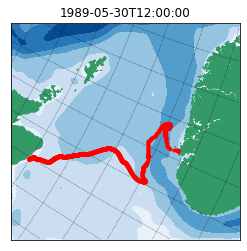

In [15]:
# Bottom topography background
depth_levels = [25, 50, 100, 250, 500, 1000, 2500]
plt.contourf(Xc, Yc, np.log(subgrid.h), 
             levels=np.log(depth_levels), cmap='Blues')

# Landmask
plt.fill(Xcoast, Ycoast, color=[0.2, 0.6, 0.4])

# Graticule
plt.contour(Xc, Yc, subgrid.lon_rho, levels=range(-14, 10, 2),
            linewidths=0.5, linestyles=':', colors='black')
plt.contour(Xc, Yc, subgrid.lat_rho, levels=range(55, 63),
            linewidths=0.5, linestyles=':', colors='black')

# Particles
plt.plot(X, Y, 'r.')

# Time stamp
plt.title(pf.time(t))

# Strip grid indices
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

# Set aspect ratio amd restrict to the subgrid
plt.axis("image")
plt.axis((i0-0.5, i1-0.5, j0-0.5, j1-0.5));

## Trajectories

A trajectory is the time series of particle positions for a given particle.
The standard output format of LADiM optimizes access to particle distributions at
a given time. Extracting trajectories is possible, but may be slow. 

In [13]:
# Extract some trajectoris

trajs = []
for pid in range(10, pf.num_particles, 20):
    trajs.append(pf.trajectory(pid))

(50.0, 150.0, 50.0, 140.0)

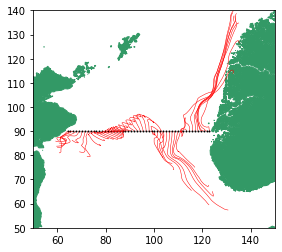

In [14]:
# Plot the trajectories

# Plot background land mask
# plt.pcolormesh(Xb, Yb, M, cmap=[0.2, 0.6, 0.4])
plt.fill(Xcoast, Ycoast, color=[0.2, 0.6, 0.4])
# Plot the trajectories
for traj in trajs:
    plt.plot(traj.X, traj.Y, color='red', linewidth=0.5)
    # Highlight start position
    plt.plot(traj.X[0], traj.Y[0], 'ko', markersize=1)

# Aspect ratio
plt.axis('image');
plt.axis((50, 150, 50, 140))